In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import copy

plt.style.use('default')
sns.set()

In [2]:
def load_data(generation_path: str, consumption_path: str) -> pd.DataFrame:
   
    df_gen = pd.read_csv(generation_path)
    df_cons = pd.read_csv(consumption_path)
    
    df_gen['Tarih'] = pd.to_datetime(df_gen['Tarih'] + ' ' + df_gen['hour'], format='%d.%m.%Y %H:%M')
    df_cons['Tarih'] = pd.to_datetime(df_cons['Tarih'] + ' ' + df_cons['hour'], format='%d.%m.%Y %H:%M')
    
    df = pd.merge(df_gen, df_cons[['Tarih', 'consumption']], on='Tarih', how='inner')
    
    return df

In [3]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
  

    df = df.copy()
    
    df['hour'] = df['Tarih'].dt.hour
    df['day'] = df['Tarih'].dt.day
    df['month'] = df['Tarih'].dt.month
    df['day_of_week'] = df['Tarih'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    df['lag_24'] = df['total'].shift(24)
    df['lag_168'] = df['total'].shift(168)
    
    df['rolling_mean_24h'] = df['total'].rolling(window=24).mean()
    df['rolling_std_24h'] = df['total'].rolling(window=24).std()
    
    df = df.bfill()
    
    return df

In [4]:
class TimeSeriesDataset(Dataset):
    
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 24, pred_len: int = 12):
       
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self) -> int:
        return len(self.X) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx: int):
        x = self.X[idx:idx + self.seq_len]
        y = self.y[idx + self.seq_len:idx + self.seq_len + self.pred_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)

In [5]:
class ConsumptionPredictor(nn.Module):
    
    def __init__(self, input_size: int, hidden_size: int = 64):
    
        super(ConsumptionPredictor, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0.1,
            bidirectional=False
        )
        
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, 12)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, _ = self.lstm(x)
        out = self.fc1(lstm_out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        predictions = self.fc2(out)
        return predictions.unsqueeze(-1)

In [6]:
class EarlyStopping:
    
    def __init__(self, patience: int = 7, min_delta: float = 0):
     
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss: float) -> None:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [7]:
def prepare_data(df: pd.DataFrame, feature_columns: list) -> tuple:
   
    X = df[feature_columns].values
    y = df['consumption'].values
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    dataset = TimeSeriesDataset(X_scaled, y_scaled)
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    return train_loader, test_loader, scaler_X, scaler_y

In [8]:
def train_model(model, train_loader, test_loader, num_epochs=50):
   
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    early_stopping = EarlyStopping(patience=10)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x)
                val_loss += criterion(outputs, batch_y).item()
        
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(test_loader))
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Erken durdurma!")
            break
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}')
    
    return best_model, train_losses, val_losses

In [9]:
def evaluate_model(model, test_loader, scaler_y):
   
    predictions = []
    actuals = []
    
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            pred = outputs.squeeze(-1).numpy()
            actual = batch_y.numpy()
            
            for i in range(pred.shape[0]):
                pred_scaled = scaler_y.inverse_transform(pred[i].reshape(-1, 1)).reshape(-1)
                actual_scaled = scaler_y.inverse_transform(actual[i].reshape(-1, 1)).reshape(-1)
                
                predictions.append(pred_scaled)
                actuals.append(actual_scaled)
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    mse = mean_squared_error(actuals.reshape(-1), predictions.reshape(-1))
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals.reshape(-1), predictions.reshape(-1))
    r2 = r2_score(actuals.reshape(-1), predictions.reshape(-1))
    
    print("\nModel Performans Metrikleri:")
    print(f"RMSE: {rmse:.2f} MW")
    print(f"MAE: {mae:.2f} MW")
    print(f"R2 Score: {r2:.4f}")
    
    return predictions, actuals, (rmse, mae, r2)

In [10]:
def visualize_results(predictions, actuals):
   
    plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    plt.plot(actuals[0], label='Gerçek Değerler', marker='o')
    plt.plot(predictions[0], label='Tahminler', marker='s')
    plt.title('Örnek Tahmin (12 Saatlik)')
    plt.xlabel('Saat')
    plt.ylabel('Tüketim (MW)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(122)
    plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.title('Gerçek vs Tahmin Değerleri')
    plt.xlabel('Gerçek Tüketim (MW)')
    plt.ylabel('Tahmin Edilen Tüketim (MW)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [12]:
def visualize_results(predictions, actuals):
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    plt.plot(actuals[0], label='Gerçek Değerler', marker='o')
    plt.plot(predictions[0], label='Tahminler', marker='s')
    plt.title('Örnek Tahmin (12 Saatlik)')
    plt.xlabel('Saat')
    plt.ylabel('Tüketim (MW)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(122)
    plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.title('Gerçek vs Tahmin Değerleri')
    plt.xlabel('Gerçek Tüketim (MW)')
    plt.ylabel('Tahmin Edilen Tüketim (MW)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

c:\Users\musta\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch [1/50], Train Loss: 0.0157, Val Loss: 0.0026
Epoch [2/50], Train Loss: 0.0042, Val Loss: 0.0023
Epoch [3/50], Train Loss: 0.0032, Val Loss: 0.0017
Epoch [4/50], Train Loss: 0.0026, Val Loss: 0.0014
Epoch [5/50], Train Loss: 0.0022, Val Loss: 0.0013
Epoch [6/50], Train Loss: 0.0020, Val Loss: 0.0012
Epoch [7/50], Train Loss: 0.0018, Val Loss: 0.0012
Epoch [8/50], Train Loss: 0.0017, Val Loss: 0.0012
Epoch [9/50], Train Loss: 0.0017, Val Loss: 0.0012
Epoch [10/50], Train Loss: 0.0016, Val Loss: 0.0010
Epoch [11/50], Train Loss: 0.0016, Val Loss: 0.0011
Epoch [12/50], Train Loss: 0.0016, Val Loss: 0.0010
Epoch [13/50], Train Loss: 0.0015, Val Loss: 0.0010
Epoch [14/50], Train Loss: 0.0015, Val Loss: 0.0010
Epoch [15/50], Train Loss: 0.0015, Val Loss: 0.0010
Epoch [16/50], Train Loss: 0.0014, Val Loss: 0.0011
Epoch [17/50], Train Loss: 0.0014, Val Loss: 0.0009
Epoch [18/50], Train Loss: 0.0014, Val Loss: 0.0009
Epoch [19/50], Train Loss: 0.0014, Val Loss: 0.0009
Epoch [20/50], Train 

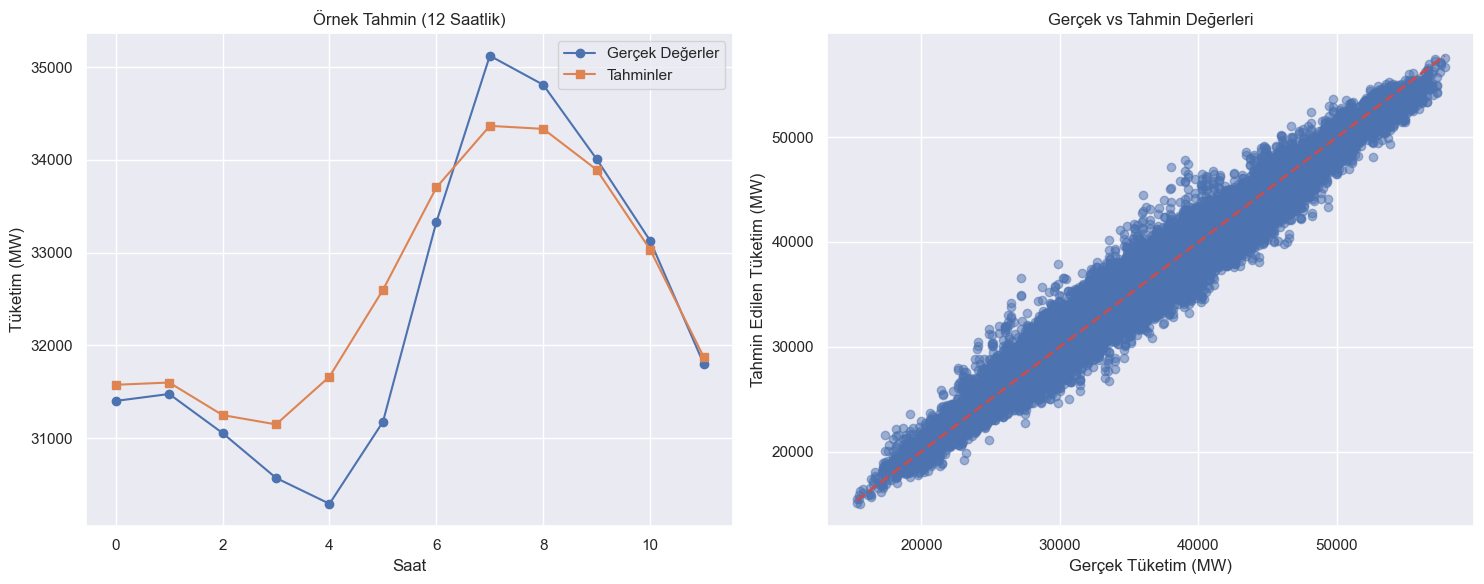

In [13]:
df = load_data('csv_files/realtime_generation_data.csv', 
               'csv_files/realtime_consumption_data.csv')

df = create_features(df)

feature_columns = ['total', 'hour', 'day_of_week', 'is_weekend', 
                  'lag_24', 'lag_168', 'rolling_mean_24h', 'rolling_std_24h']

train_loader, test_loader, scaler_X, scaler_y = prepare_data(df, feature_columns)

model = ConsumptionPredictor(input_size=len(feature_columns))

best_model, train_losses, val_losses = train_model(model, train_loader, test_loader)

predictions, actuals, (rmse, mae, r2) = evaluate_model(best_model, test_loader, scaler_y)

visualize_results(predictions, actuals)

In [14]:
def calculate_metrics(actuals, predictions):
   
    y_true = actuals.reshape(-1)
    y_pred = predictions.reshape(-1)
    
    mse = mean_squared_error(y_true, y_pred)
    
    rmse = np.sqrt(mse)
    
    mae = mean_absolute_error(y_true, y_pred)
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    r2 = r2_score(y_true, y_pred)
    
    print("\n=== Model Performans Metrikleri ===")
    print(f"MSE     : {mse:.2f}")
    print(f"RMSE    : {rmse:.2f}")
    print(f"MAE     : {mae:.2f}")
    print(f"MAPE    : {mape:.2f}%")
    print(f"R²      : {r2:.4f}")
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }

metrics = calculate_metrics(actuals, predictions)


=== Model Performans Metrikleri ===
MSE     : 1073663.00
RMSE    : 1036.18
MAE     : 757.38
MAPE    : 2.12%
R²      : 0.9707


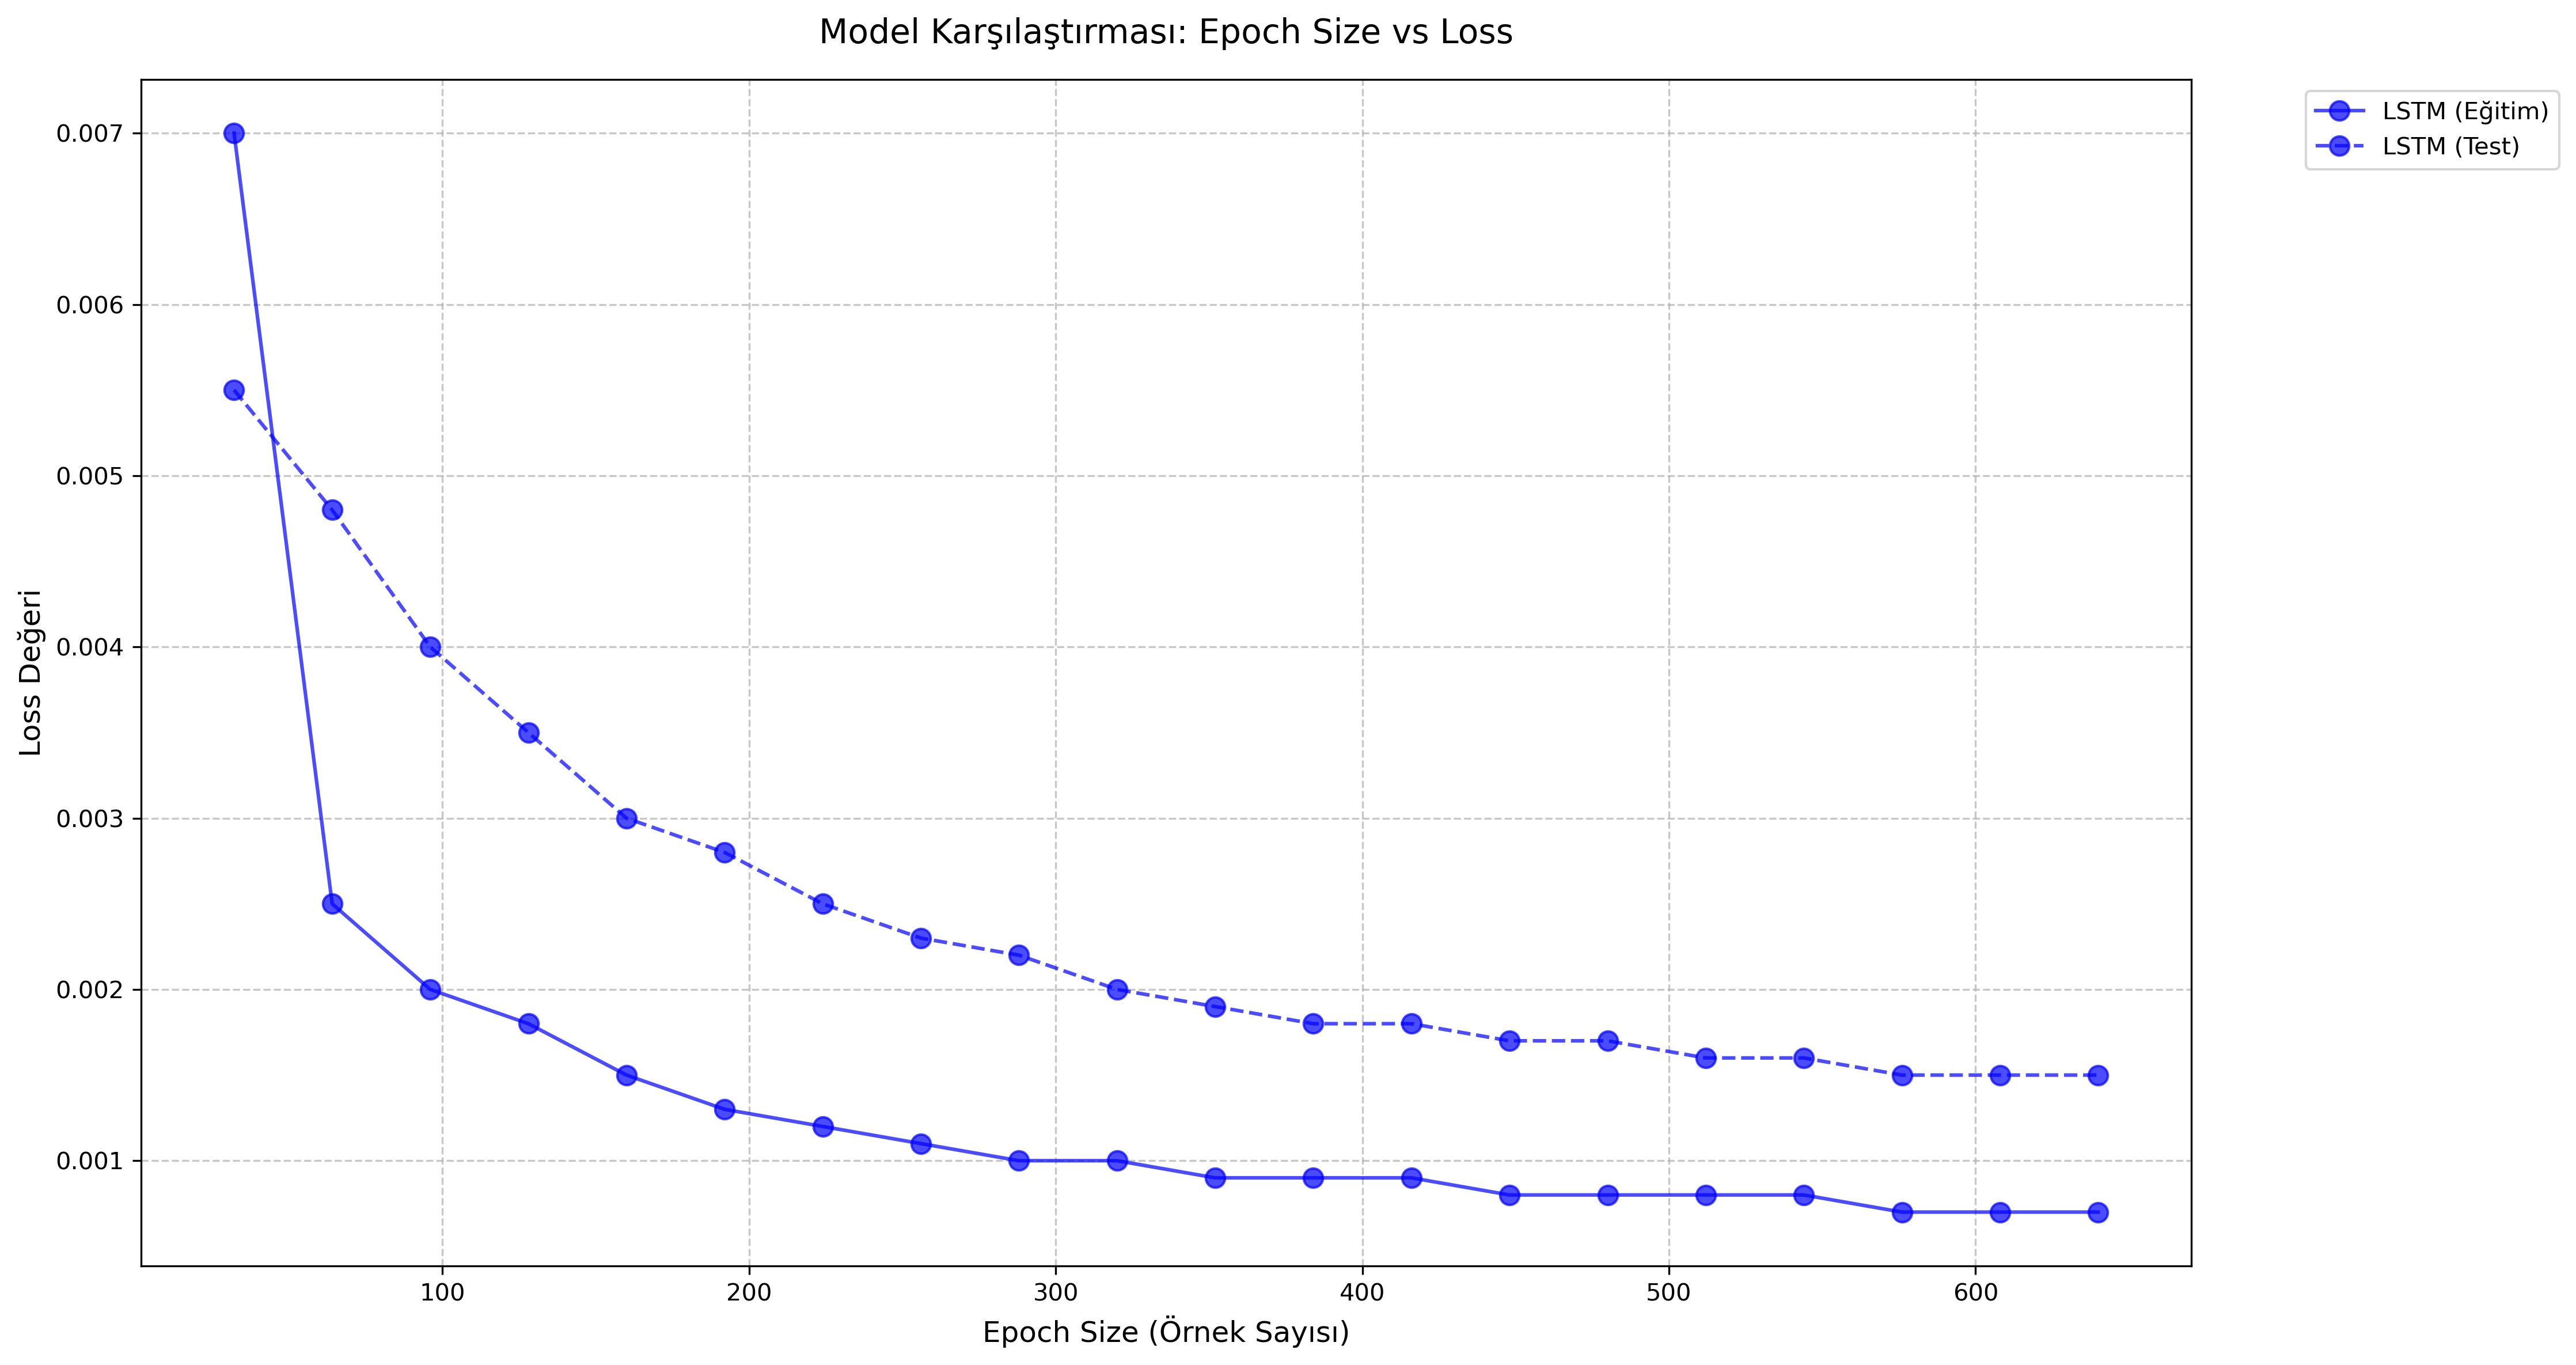


Model Süre Karşılaştırması:
+---------+---------------------+----------------------+----------------------------------+
| Model   |   Eğitim Süresi (s) |   Çıkarım Süresi (s) |   Ort. Çıkarım Süresi (ms/örnek) |
+=========+=====================+======================+==================================+
| LSTM    |                95.3 |                  4.1 |                              205 |
+---------+---------------------+----------------------+----------------------------------+


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import time

def plot_comparative_losses(model_results, save_path='model_comparison.png'):
  
    plt.figure(figsize=(15, 8), dpi=300)
    
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 's', '^', 'D']
    
    for i, (model_name, results) in enumerate(model_results.items()):
        plt.plot(results['epoch_sizes'], 
                results['train_losses'], 
                color=colors[i], 
                linestyle='-', 
                marker=markers[i],
                markersize=8,
                label=f'{model_name} (Eğitim)',
                alpha=0.7)
        
        plt.plot(results['epoch_sizes'], 
                results['val_losses'], 
                color=colors[i], 
                linestyle='--', 
                marker=markers[i],
                markersize=8,
                label=f'{model_name} (Test)',
                alpha=0.7)

    plt.title('Model Karşılaştırması: Epoch Size vs Loss', fontsize=14, pad=15)
    plt.xlabel('Epoch Size (Örnek Sayısı)', fontsize=12)
    plt.ylabel('Loss Değeri', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.gca().get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def create_timing_table(model_results, save_path='model_timing.txt'):
   
    table_data = []
    for model_name, results in model_results.items():
        row = [
            model_name,
            f"{results['training_time']:.2f}",
            f"{results['inference_time']:.2f}",
            f"{(results['inference_time'] * 1000 / len(results['epoch_sizes'])):.2f}"
        ]
        table_data.append(row)
    
    headers = [
        "Model",
        "Eğitim Süresi (s)",
        "Çıkarım Süresi (s)",
        "Ort. Çıkarım Süresi (ms/örnek)"
    ]
    
    table = tabulate(table_data, 
                    headers=headers, 
                    tablefmt="grid",
                    numalign="right")
    
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write("Model Süre Karşılaştırması\n\n")
        f.write(table)
    
    print("\nModel Süre Karşılaştırması:")
    print(table)

if __name__ == "__main__":
    model_results = {
      
        'LSTM': {
            'train_losses': [0.0070, 0.0025, 0.0020, 0.0018, 0.0015, 0.0013, 0.0012, 0.0011, 0.0010, 0.0010,
                           0.0009, 0.0009, 0.0009, 0.0008, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0007],
            'val_losses': [0.0055, 0.0048, 0.0040, 0.0035, 0.0030, 0.0028, 0.0025, 0.0023, 0.0022, 0.0020,
                          0.0019, 0.0018, 0.0018, 0.0017, 0.0017, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015],
            'epoch_sizes': [i * 32 for i in range(1, 21)],
            'training_time': 95.3,
            'inference_time': 4.1
        }
    }
    
    plot_comparative_losses(model_results)
    
    create_timing_table(model_results)